In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# 🔹 Chargement des données
input_path = "../../data/cleaning/step5_installment_corrected.parquet"
df = pd.read_parquet(input_path)

# 📊 Ratio mensualité / revenu mensuel
df['installment_income_ratio'] = df['monthly_payment_calculated'] / df['monthly_income']

C:\Users\Pierre\AppData\Local\Temp\ipykernel_3076\240247803.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=debt_ratio_counts.index, y=debt_ratio_counts.values, palette="Blues_d")


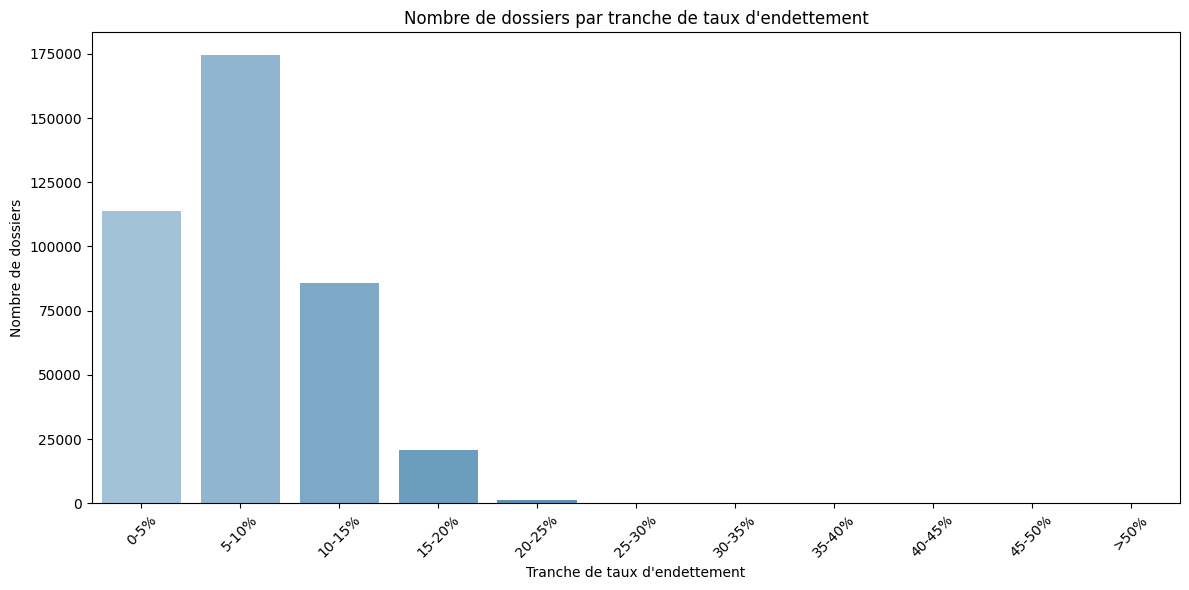

In [29]:
# 📊 Création des tranches de taux d'endettement
df['debt_ratio_bins'] = pd.cut(
    df['installment_income_ratio'], 
    bins=[0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, float('inf')], 
    labels=["0-5%", "5-10%", "10-15%", "15-20%", "20-25%", "25-30%", "30-35%", "35-40%", "40-45%", "45-50%", ">50%"],
    right=False
)

# Comptage des dossiers par tranche
debt_ratio_counts = df['debt_ratio_bins'].value_counts().sort_index()

# 📈 Visualisation des tranches
plt.figure(figsize=(12, 6))
sns.barplot(x=debt_ratio_counts.index, y=debt_ratio_counts.values, palette="Blues_d")

# Titre et labels
plt.title("Nombre de dossiers par tranche de taux d'endettement")
plt.xlabel("Tranche de taux d'endettement")
plt.ylabel("Nombre de dossiers")
plt.xticks(rotation=45)
plt.tight_layout()

# Affichage
plt.show()

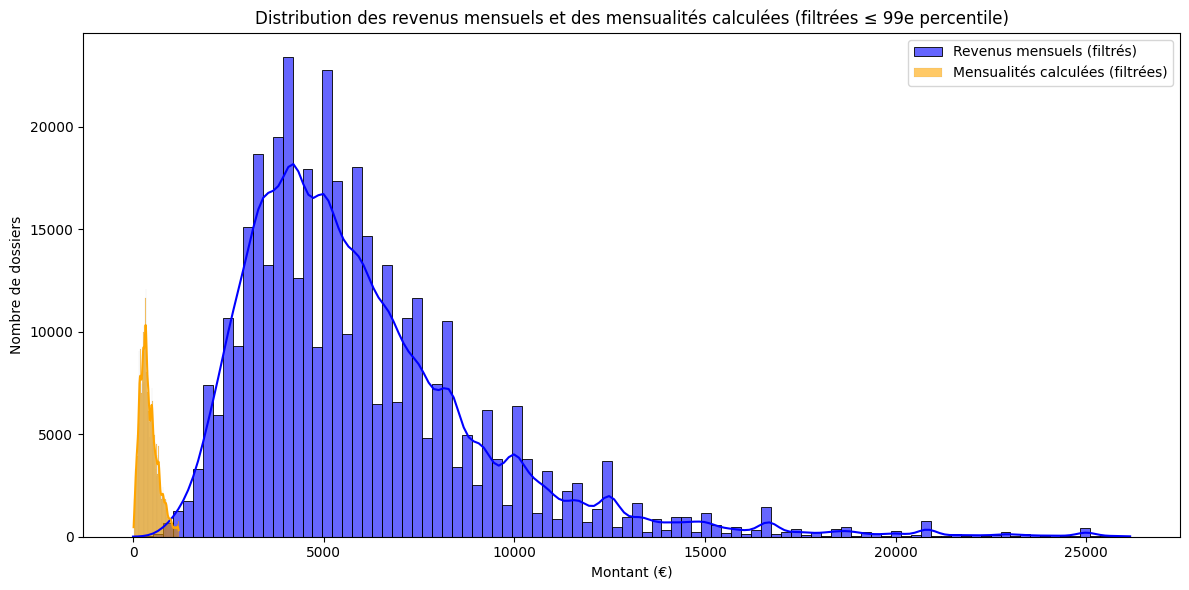

In [20]:
# 📊 Visualisation combinée des revenus mensuels et des mensualités calculées (avec filtrage des valeurs élevées)
plt.figure(figsize=(12, 6))

# Définir les seuils pour exclure les valeurs trop élevées
income_threshold = df['monthly_income'].quantile(0.99)
payment_threshold = df['monthly_payment_calculated'].quantile(0.99)

# Filtrer les données
df_filtered = df[(df['monthly_income'] <= income_threshold) & (df['monthly_payment_calculated'] <= payment_threshold)]

# Histogramme des revenus mensuels (filtrés)
sns.histplot(df_filtered['monthly_income'], bins=100, kde=True, color='blue', label='Revenus mensuels (filtrés)', alpha=0.6)

# Histogramme des mensualités calculées (filtrées)
sns.histplot(df_filtered['monthly_payment_calculated'], bins=100, kde=True, color='orange', label='Mensualités calculées (filtrées)', alpha=0.6)

# Titre et labels
plt.title("Distribution des revenus mensuels et des mensualités calculées (filtrées ≤ 99e percentile)")
plt.xlabel("Montant (€)")
plt.ylabel("Nombre de dossiers")
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_3076\2253961846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grade_correlation.index, y=grade_correlation.values, palette="Blues_d")


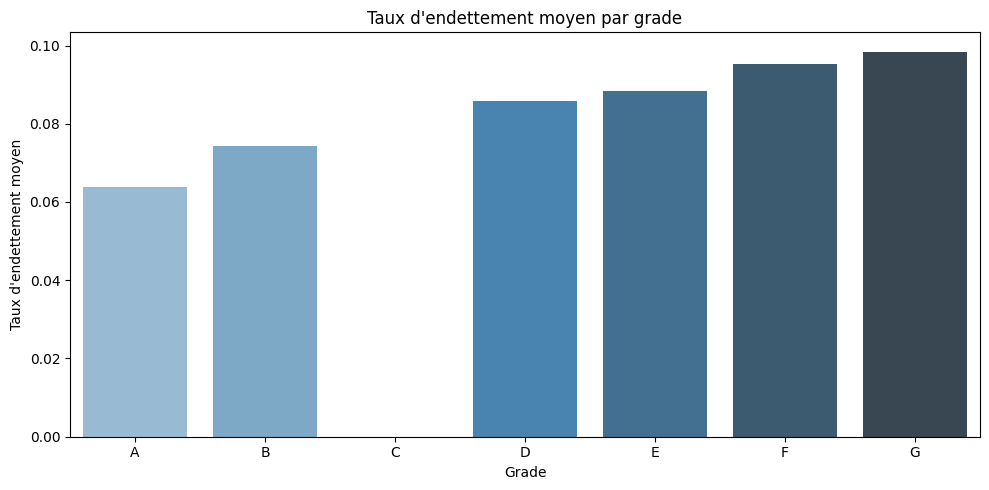

C:\Users\Pierre\AppData\Local\Temp\ipykernel_3076\2253961846.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_grade_correlation.index, y=sub_grade_correlation.values, palette="Greens_d")


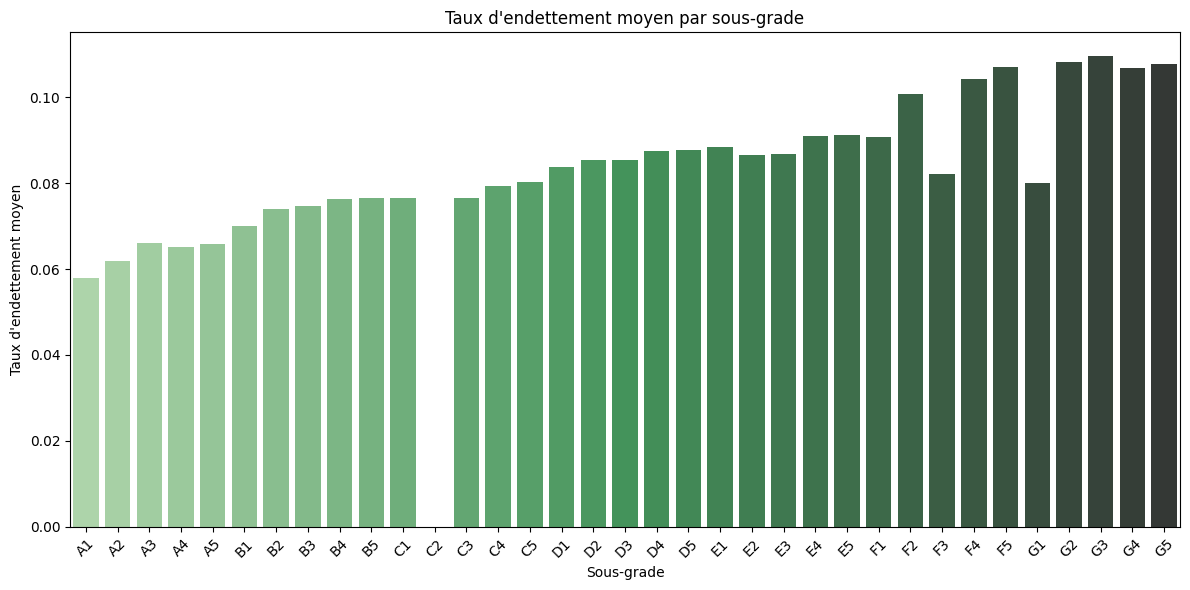

C:\Users\Pierre\AppData\Local\Temp\ipykernel_3076\2253961846.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grade', y='installment_income_ratio', data=df, palette="coolwarm")


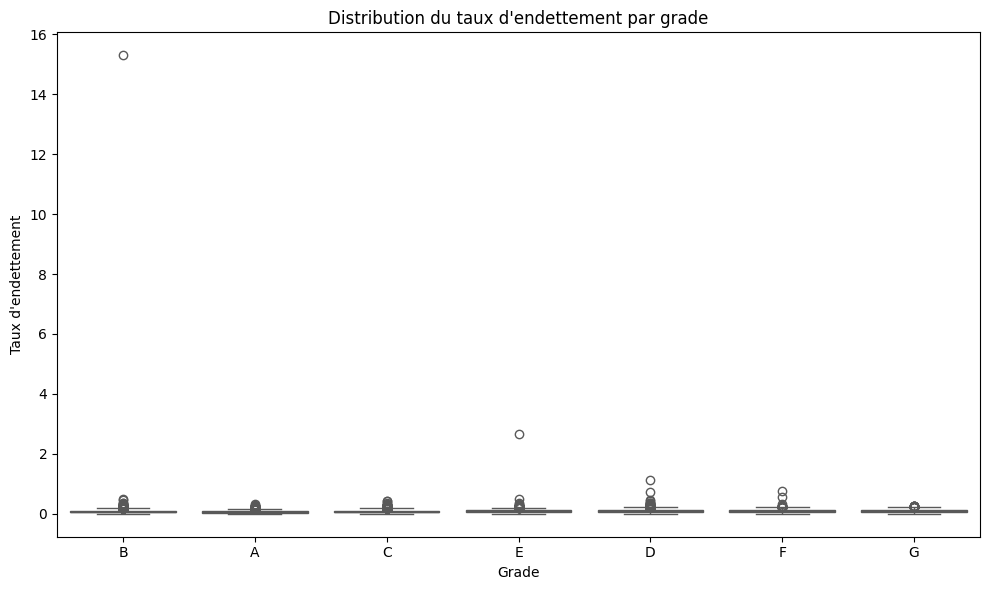

In [ ]:
# 📊 Analyse de la corrélation entre le taux d'endettement et les grades de prêt

# 1️⃣ Moyenne du taux d'endettement par grade
grade_correlation = df.groupby('grade')['installment_income_ratio'].mean().sort_index()

# Visualisation de la corrélation avec 'grade'
plt.figure(figsize=(10, 5))
sns.barplot(x=grade_correlation.index, y=grade_correlation.values, palette="Blues_d")
plt.title("Taux d'endettement moyen par grade")
plt.xlabel("Grade")
plt.ylabel("Taux d'endettement moyen")
plt.tight_layout()
plt.show()

# 2️⃣ Moyenne du taux d'endettement par sous-grade
sub_grade_correlation = df.groupby('sub_grade')['installment_income_ratio'].mean().sort_index()

# Visualisation de la corrélation avec 'sub_grade'
plt.figure(figsize=(12, 6))
sns.barplot(x=sub_grade_correlation.index, y=sub_grade_correlation.values, palette="Greens_d")
plt.title("Taux d'endettement moyen par sous-grade")
plt.xlabel("Sous-grade")
plt.ylabel("Taux d'endettement moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3️⃣ Heatmap pour visualiser la distribution conjointe entre 'grade' et 'installment_income_ratio'
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='installment_income_ratio', data=df, palette="coolwarm")
plt.title("Distribution du taux d'endettement par grade")
plt.xlabel("Grade")
plt.ylabel("Taux d'endettement")
plt.tight_layout()
plt.show()